# The EPA dataset

[Simon Dobson](mailto:simon.dobson@st-andrews.ac.uk) <br>
School of Computer Science, University of St Andrews, Scotland UK

In [300]:
import json
import pickle
from copy import deepcopy
from io import BytesIO
from datetime import datetime, timedelta
import numpy
import netCDF4 as nc
from pandas import DataFrame
from geopandas import GeoDataFrame, GeoSeries, read_file
from networkx import Graph

from sensor_placement import *
from sensor_placement.data import *
from sensor_placement.folium import *
from sensor_placement.matplotlib import *

import logging
logging.basicConfig(level=logging.DEBUG)

from pyproj import CRS, Transformer, Geod
import folium
from PIL import Image
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint, shape
from shapely.ops import cascaded_union

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm, ListedColormap, to_rgba
from matplotlib.patches import Circle
from mpl_toolkits.basemap import Basemap

import contextily

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [2]:
uk_grid_crs = CRS.from_string('EPSG:27700')   # UK national grid
latlon_crs = CRS.from_string('EPSG:4326')     # global Mercator (WGS 84)
web_crs = CRS.from_string('EPSG:3857')        # web Mercator

proj = Transformer.from_crs(uk_grid_crs, latlon_crs)
proj_inv = Transformer.from_crs(latlon_crs, uk_grid_crs)
proj_extent = Transformer.from_crs(latlon_crs, web_crs)

In [3]:
boundaries_filename = 'datasets/UK_BUC.geojson'
with open(boundaries_filename, 'r') as fh:
    counties_json = json.load(fh)

In [4]:
counties = GeoDataFrame({'county': map(lambda c: c['properties']['ctyua18nm'], counties_json['features']),
                         'geometry': map(lambda c: shape(c['geometry']), counties_json['features'])})

## Loading the dataset

In [5]:
epa_filename='datasets/epa_daily_2022-03-07_2022-03-14.nc'
epa = nc.Dataset(epa_filename)

In [6]:
epa.description

'EPA tipping bucket daily data (2022-03-07 -- 2022-03-14)'

In [7]:
epastations = stations(epa)

/home/sd80/programming/sensor-placement/venv3/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [8]:
points = MultiPoint(list(epastations['geometry']))
epa_boundary = points.buffer(1).buffer(-1).buffer(0.05)

In [9]:
epa_map = folium.Map(location=(55, -3), tiles="Stamen Terrain", zoom_start=6)

# add the stations
samplePoints(epastations, name='EPA stations').add_to(epa_map)

# add the boundary
hull_layer = folium.FeatureGroup(name='Boundary')
folium.GeoJson(epa_boundary).add_to(hull_layer)
hull_layer.add_to(epa_map)

# add a layer countrol
_ = folium.LayerControl().add_to(epa_map)

In [10]:
epa_map

## Interpolating from the full dataset

In [44]:
x_min, y_min, x_max, y_max = epa_boundary.bounds

xg_min, yg_min = proj_inv.transform(y_min, x_min)
xg_max, yg_max = proj_inv.transform(y_max, x_max)
es = int((xg_max - xg_min) / 1000) + 1
ns = int((yg_max - yg_min) / 1000) + 1

xs = numpy.linspace(x_min, x_max, num=es, endpoint=True)
ys = numpy.linspace(y_min, y_max, num=ns, endpoint=True)

In [13]:
%%timeit -n1 -r1

global epa_tensor
epa_tensor = NNNI(epastations, epa_boundary, ys, xs, cores=-2)

epa_tensor.save('datasets/epa_tensor.nc')

KeyboardInterrupt: 

In [13]:
#with open('datasets/epa_tensor.pickle', 'r') as fh:
#    epa_tensor = pickle.load(fh)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [14]:
epa_tensor = NNNI.load('datasets/epa_tensor.nc')

In [26]:
epa_tensor._tensor.shape

(649, 497, 965)

In [9]:
epa_rainfall = epa['rainfall_amount'][:, :]
epa_time = epa['time'][:]

In [10]:
epa_rainfall_day = epa_rainfall[5]   # a day with some rain :-)

In [18]:
epa_rainfall_day.shape

(965,)

In [17]:
%%timeit -n1 -r1

global epa_interpolated_rainfall
epa_interpolated_rainfall = epa_tensor.apply(epa_rainfall_day, clipped=True)

6.97 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
epa_interpolated_map = folium.Map(location=(53.5, -3), tiles="Stamen Terrain", zoom_start=6)

# add the stations
#samplePoints(epastations, epa_rainfall_day, name='EPA stations').add_to(epa_interpolated_map)

# add the boundary
hull_layer = folium.FeatureGroup(name='Boundary')
folium.GeoJson(epa_boundary).add_to(hull_layer)
hull_layer.add_to(epa_interpolated_map)

# add the heat map
heatmap(epa_tensor, epa_interpolated_rainfall, name='Rainfall').add_to(epa_interpolated_map)

# add a layer countrol
_ = folium.LayerControl().add_to(epa_interpolated_map)

In [19]:
epa_interpolated_map

In [25]:
img_data = epa_interpolated_map._to_png(5)
img = Image.open(BytesIO(img_data))
img.save('datasets/epa-interpolated-rainfall.png')

## A smaller sub-set

In [11]:
bottom, left, top, right = 50.0, -5.7, 51.89, -1.23
cornwall = Polygon([(left, bottom), (left, top), (right, top), (right, bottom), (left, bottom)])

In [12]:
epastations_cornwall = epastations.loc[epastations.geometry.within(cornwall)]

In [13]:
len(epastations_cornwall)

216

In [14]:
epa_boundary_cornwall = epa_boundary.intersection(cornwall)

x_min, y_min, x_max, y_max = epa_boundary_cornwall.bounds
xg_min, yg_min = proj_inv.transform(y_min, x_min)
xg_max, yg_max = proj_inv.transform(y_max, x_max)
es = int((xg_max - xg_min) / 1000) + 1
ns = int((yg_max - yg_min) / 1000) + 1
xs_cornwall = numpy.linspace(x_min, x_max, num=es, endpoint=True)
ys_cornwall = numpy.linspace(y_min, y_max, num=ns, endpoint=True)

In [17]:
%%timeit -n1 -r1

global epa_tensor_cornwall
epa_tensor_cornwall = NNNI(epastations_cornwall, epa_boundary_cornwall, xs_cornwall, ys_cornwall, cores=1)

epa_tensor_cornwall.save('datasets/epa_tensor_cornwall.nc')
with open('datasets/epa_tensor_cornwall.pickle', 'wb') as fh:
    pickle.dump(epa_tensor_cornwall, fh)

DEBUG:sensor_placement:Saving tensor to datasets/epa_tensor_cornwall.nc


In [15]:
#with open('datasets/epa_tensor_cornwall.pickle', 'rb') as fh:
#    epa_tensor_cornwall = pickle.load(fh)
epa_tensor_cornwall = NNNI.load('datasets/epa_tensor_cornwall.nc')

DEBUG:sensor_placement:Loading tensor from datasets/epa_tensor_cornwall.nc (class NNNI)


IndexError: index 205 is out of bounds for axis 1 with size 205

In [18]:
epa_rainfall_cornwall = numpy.zeros((len(epa_tensor_cornwall.samplePoints()), ))

In [19]:
for i in range(len(epastations_cornwall.index)):
    s = epastations_cornwall.index[i]
    j = epastations.index.get_loc(s)
    epa_rainfall_cornwall[i] = epa_rainfall_day[j]

In [20]:
epa_interpolated_rainfall_cornwall = epa_tensor_cornwall.apply(epa_rainfall_cornwall, clipped=True)

In [24]:
epa_interpolated_rainfall_cornwall.shape

(313, 205)

In [28]:
epa_interpolated_cornwall_map = folium.Map(location=(51.0, -3.5), tiles="Stamen Terrain", zoom_start=9)

# add the stations
#samplePoints(epastations_cornwall, epa_rainfall_cornwall, name='EPA stations').add_to(epa_interpolated_cornwall_map)

# add the boundary
hull_layer = folium.FeatureGroup(name='Boundary')
folium.GeoJson(epa_boundary_cornwall).add_to(hull_layer)
hull_layer.add_to(epa_interpolated_cornwall_map)

# add the heat map
heatmap(epa_tensor_cornwall, epa_interpolated_rainfall_cornwall, name='Rainfall').add_to(epa_interpolated_cornwall_map)

# add a layer countrol
_ = folium.LayerControl().add_to(epa_interpolated_cornwall_map)

In [29]:
epa_interpolated_cornwall_map

In [119]:
img_data = epa_interpolated_cornwall_map._to_png(5)
img = Image.open(BytesIO(img_data))
img.save('datasets/epa-interpolated-cornwall-rainfall-clear.png')

## Interpolation from a more sparse set

In [30]:
# Fraction of stations to retain
p = 0.6

In [31]:
rng = numpy.random.default_rng()
retain_mask = [rng.random() <= p for _ in range(len(epastations_cornwall))]
epastations_cornwall_reduced = epastations_cornwall[retain_mask]

In [32]:
epa_tensor_cornwall_reduced = NNNI(epastations_cornwall_reduced, epa_boundary_cornwall, xs_cornwall, ys_cornwall, cores=1)

INFO:sensor_placement:NNI tensor initialised to use 1 cores
DEBUG:sensor_placement:Computing Voronoi diagram
DEBUG:sensor_placement:Computing grid
DEBUG:sensor_placement:Tensor created with shape (313, 205, 132)
DEBUG:sensor_placement:Computing weights for cell 22
DEBUG:sensor_placement:Computing weights for cell 34
DEBUG:sensor_placement:Computing weights for cell 35
DEBUG:sensor_placement:Computing weights for cell 46
DEBUG:sensor_placement:Computing weights for cell 49
DEBUG:sensor_placement:Computing weights for cell 54
DEBUG:sensor_placement:Computing weights for cell 62
DEBUG:sensor_placement:Computing weights for cell 66
DEBUG:sensor_placement:Computing weights for cell 69
DEBUG:sensor_placement:Computing weights for cell 70
DEBUG:sensor_placement:Computing weights for cell 73
DEBUG:sensor_placement:Computing weights for cell 75
DEBUG:sensor_placement:Computing weights for cell 80
DEBUG:sensor_placement:Computing weights for cell 83
DEBUG:sensor_placement:Computing weights for c

In [33]:
epa_rainfall_cornwall_reduced = numpy.zeros((len(epa_tensor_cornwall_reduced.samplePoints()), ))

In [34]:
for i in range(len(epastations_cornwall_reduced.index)):
    s = epastations_cornwall_reduced.index[i]
    j = epastations.index.get_loc(s)
    epa_rainfall_cornwall_reduced[i] = epa_rainfall_day[j]

In [35]:
epa_interpolated_rainfall_cornwall_reduced = epa_tensor_cornwall_reduced.apply(epa_rainfall_cornwall_reduced, clipped=True)

In [36]:
epa_interpolated_cornwall_reduced_map = folium.Map(location=(51.0, -3.5), tiles="Stamen Terrain", zoom_start=9)

# add the stations
#samplePoints(epastations_cornwall_reduced, epa_rainfall_cornwall_reduced, name='EPA stations').add_to(epa_interpolated_cornwall_reduced_map)

# add the boundary
hull_layer = folium.FeatureGroup(name='Boundary')
folium.GeoJson(epa_boundary_cornwall).add_to(hull_layer)
hull_layer.add_to(epa_interpolated_cornwall_reduced_map)

# add the heat map
heatmap(epa_tensor_cornwall_reduced, epa_interpolated_rainfall_cornwall_reduced, name='Rainfall').add_to(epa_interpolated_cornwall_reduced_map)

# add a layer countrol
_ = folium.LayerControl().add_to(epa_interpolated_cornwall_reduced_map)

In [37]:
epa_interpolated_cornwall_reduced_map

In [118]:
img_data = epa_interpolated_cornwall_reduced_map._to_png(5)
img = Image.open(BytesIO(img_data))
img.save('datasets/epa-interpolated-cornwall-reduced-rainfall-clear.png')

## Error comparison

In [38]:
epa_interpolated_rainfall_cornwall_error = epa_interpolated_rainfall_cornwall - epa_interpolated_rainfall_cornwall_reduced

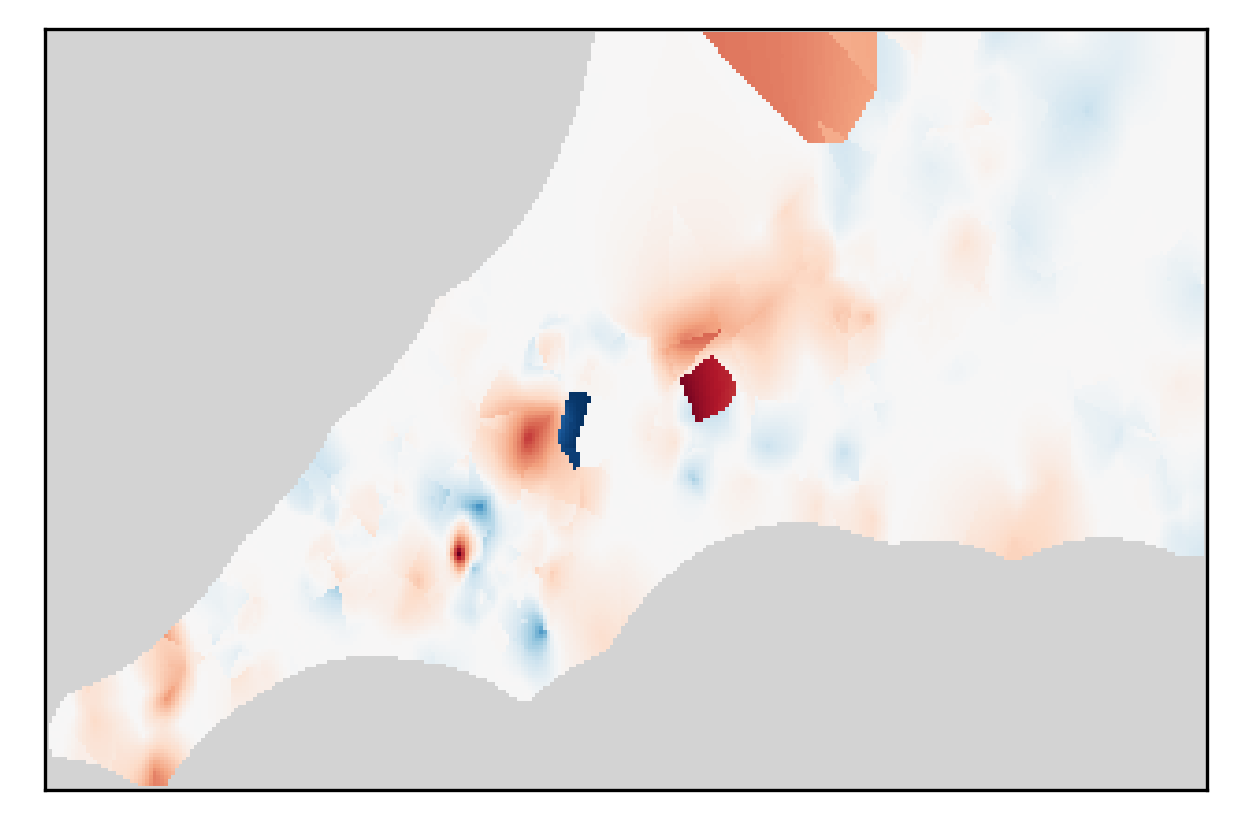

In [40]:
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
ax.patch.set_facecolor('lightgray')

norm = TwoSlopeNorm(vcenter=0.0, vmin=epa_interpolated_rainfall_cornwall_error.min(), vmax=epa_interpolated_rainfall_cornwall_error.max())
ax.imshow(epa_interpolated_rainfall_cornwall_error.T,
          cmap=cm.get_cmap('RdBu'), norm=norm, origin='lower')

plt.savefig('datasets/epa-interpolated-cornwall-reduced-rainfall-diff.png')
_ = plt.show()

In [61]:
#a = getImageCluster(38.5, -77.04, 0.02,  0.05, 13)
lon, lat = epa_boundary_cornwall.bounds[1], epa_boundary_cornwall.bounds[0]
delta_lon, delta_lat = epa_boundary_cornwall.bounds[3] - lon, epa_boundary_cornwall.bounds[2] - lat
base, bbox = tile(lon, lat, delta_lon, delta_lat, 10)

DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 768
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 821 3638
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 300
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 353 1622
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 75
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 128 1468
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 81
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 134 1349
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEB

DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 768
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 821 23156
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 105
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 158 1983
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 21
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 74 997
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 768
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 821 26113
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 765
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 818 30716
DEBUG:requests_cache.cache_c

DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 768
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 821 30870
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 768
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 821 10500
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 528
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 581 4476
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 21
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 74 467
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DE

DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 768
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 821 32768
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 768
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 821 32768
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 768
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 821 32768
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 765
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 818 32768
DEBUG:requests_cache.cache_control:Cache directives from request headers: {}
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 768
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 821 8588
DEBUG:requests_cache.cac

In [79]:
epa_tensor_cornwall._voronoi

centre  \
id                               
12   POINT (-3.12295 50.97176)   
13   POINT (-1.55859 50.88011)   
22   POINT (-2.43497 51.11663)   
23   POINT (-4.20954 50.51645)   
28   POINT (-3.70248 50.53756)   
..                         ...   
941  POINT (-3.11789 50.70112)   
951  POINT (-2.61208 51.75874)   
956  POINT (-1.91806 50.96814)   
958  POINT (-3.73944 50.39132)   
960  POINT (-3.94086 51.11661)   

                                              geometry  \
id                                                       
12   POLYGON ((-3.22193 51.01767, -3.09790 51.08091...   
13   POLYGON ((-1.72525 50.97749, -1.41881 50.87387...   
22   POLYGON ((-2.45980 51.16055, -2.42983 51.16543...   
23   POLYGON ((-4.27374 50.49827, -4.24632 50.59809...   
28   POLYGON ((-3.77161 50.54828, -3.62360 50.58806...   
..                                                 ...   
941  POLYGON ((-3.19759 50.70014, -3.11615 50.76298...   
951  POLYGON ((-2.47489 51.73930, -2.59418 51.62003...   
956  POLYGON ((-2.03838 50.93656, -2.03839 50.94867...   
958  POLYGON ((-3.82386 50.41715, -3.74539 50.43641...   
960  POLYGON ((-4.07113 51.02058, -4.02397 51.14684...   

                                         neighbourhood  \
id                                                       
12                   [53, 474, 665, 677, 733, 791, 12]   
13                  [204, 562, 609, 736, 779, 956, 13]   
22                   [89, 119, 246, 385, 738, 766, 22]   
23                   [80, 219, 297, 697, 705, 858, 23]   
28                       [173, 570, 762, 802, 890, 28]   
..                                                 ...   
941                     [107, 176, 368, 534, 870, 941]   
951                [101, 304, 671, 706, 786, 853, 951]   
956  [13, 62, 73, 168, 278, 326, 562, 585, 627, 729...   
958                     [173, 359, 648, 762, 860, 958]   
960                     [433, 696, 759, 760, 826, 960]   

                                              boundary  
id                                                      
12   POLYGON ((-3.3191596963968752 50.9071528785172...  
13   POLYGON ((-1.23 50.89242145491281, -1.23 50.71...  
22   POLYGON ((-2.271902678984723 51.14922021909969...  
23   POLYGON ((-4.086723532297708 50.30188959631223...  
28   POLYGON ((-3.745386789548417 50.43640604709143...  
..                                                 ...  
941  POLYGON ((-3.351962615433187 50.756423056826, ...  
951  POLYGON ((-2.373522961263435 51.52590469897156...  
956  POLYGON ((-2.1863690229682944 50.6398239106415...  
958  POLYGON ((-3.6098628761097884 50.4649185816587...  
960  POLYGON ((-4.076567528472572 51.02142115795169...  

[216 rows x 4 columns]

In [242]:
def drawMap(tensor, ax):
    epsg = int(latlon_crs.list_authority()[0].code)
    bounds = tensor._boundary.bounds
    m = Basemap(epsg=epsg, resolution='i',
                llcrnrlon=bounds[0], llcrnrlat=bounds[1],
                urcrnrlon=bounds[2], urcrnrlat=bounds[3],
                lon_0=-4.36, lat_0=54.7,
                ax=ax)
    m.drawcoastlines()

    #norm = TwoSlopeNorm(vcenter=0.0, vmin=epa_interpolated_rainfall_cornwall_error.min(), vmax=epa_interpolated_rainfall_cornwall_error.max())
    #n.imshow(epa_interpolated_rainfall_cornwall_error.T,
    #         cmap=cm.get_cmap('RdBu'), norm=norm, origin='lower',
    #         alpha=0.5)
    
    return m

def drawVoronoiCells(tensor, ax):
    # draw the boundarfies of the Voronoi cells
    for p in tensor._voronoi['boundary']:
        x, y = p.exterior.xy
        ax.plot(x, y, color='r', linewidth=0.1)

    # draw the sample points
    for p in tensor._voronoi['centre']:
        [(x, y)] = list(p.coords)
        ax.plot(x, y, 'go', markersize=0.3)

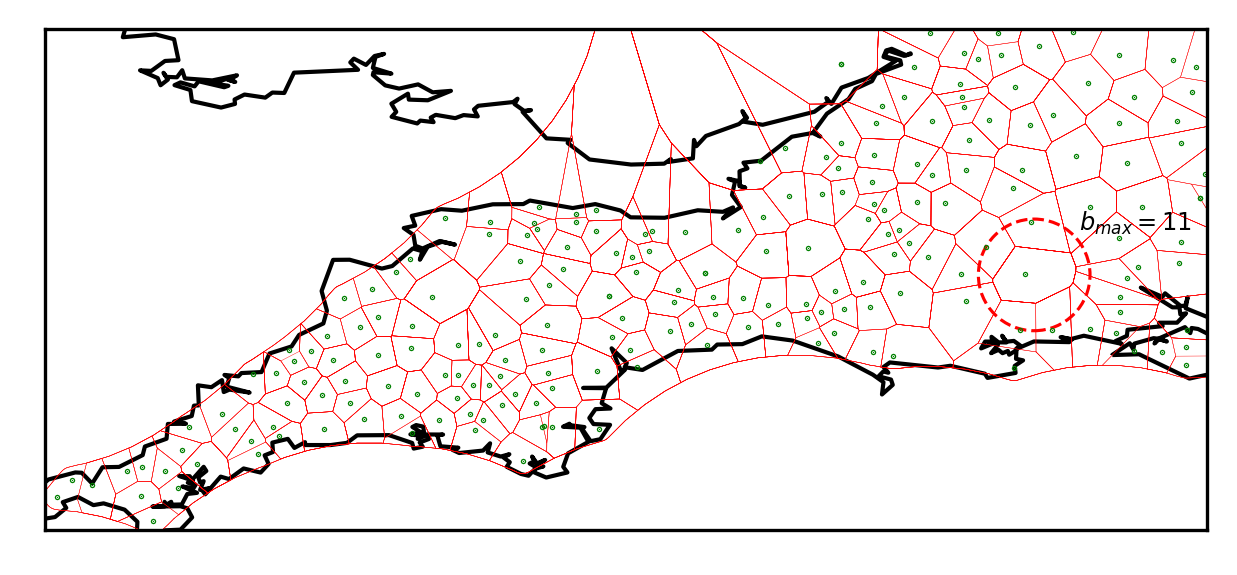

In [226]:
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

# draw the map outline
drawMap(epa_tensor_cornwall, ax)

# draw voronoi cells
drawVoronoiCells(epa_tensor_cornwall, ax)

# highlight the most-bordered samples
epa_tensor_cornwall._voronoi['bordered'] = epa_tensor_cornwall._voronoi['neighbourhood'].apply(lambda n: len(n) - 1)
b_min, b_max = epa_tensor_cornwall._voronoi['bordered'].min(), epa_tensor_cornwall._voronoi['bordered'].max()
for _, r in epa_tensor_cornwall._voronoi[epa_tensor_cornwall._voronoi['bordered'] == b_max].iterrows():
    centroid = r['geometry'].centroid
    cp = centroid.coords[0]
    bps = r['geometry'].exterior.coords
    radius = max(map(lambda p: centroid.distance(Point(p)), list(bps))) + 0.05
    c = Circle(cp, radius=radius,
              linestyle='--', linewidth=0.75, fill=False, color='r')
    ax.add_artist(c)
    ax.annotate(text='$b_{max} = ' + f'{b_max}$', xy=cp,
                xytext=(cp[0] + radius * 0.8, cp[1] + radius * 0.8), fontsize='xx-small')
    
plt.savefig('datasets/cornwall-voronoi.png', dpi=300)
_ = plt.show()

## Largest contributing sample

In [283]:
def indexOfLargestWeight(r, nth):
    ws = sorted(list(r))
    w_max = ws[-nth]
    if w_max == 0.0:
        return -1
    else:
        return numpy.where(r == w_max)[0][0]
    
def largestContributingSamples(t, nth = 1):
    return numpy.apply_along_axis(lambda r: indexOfLargestWeight(r, nth), 2, t._tensor)

In [284]:
l = largestContributingSamples(epa_tensor_cornwall)

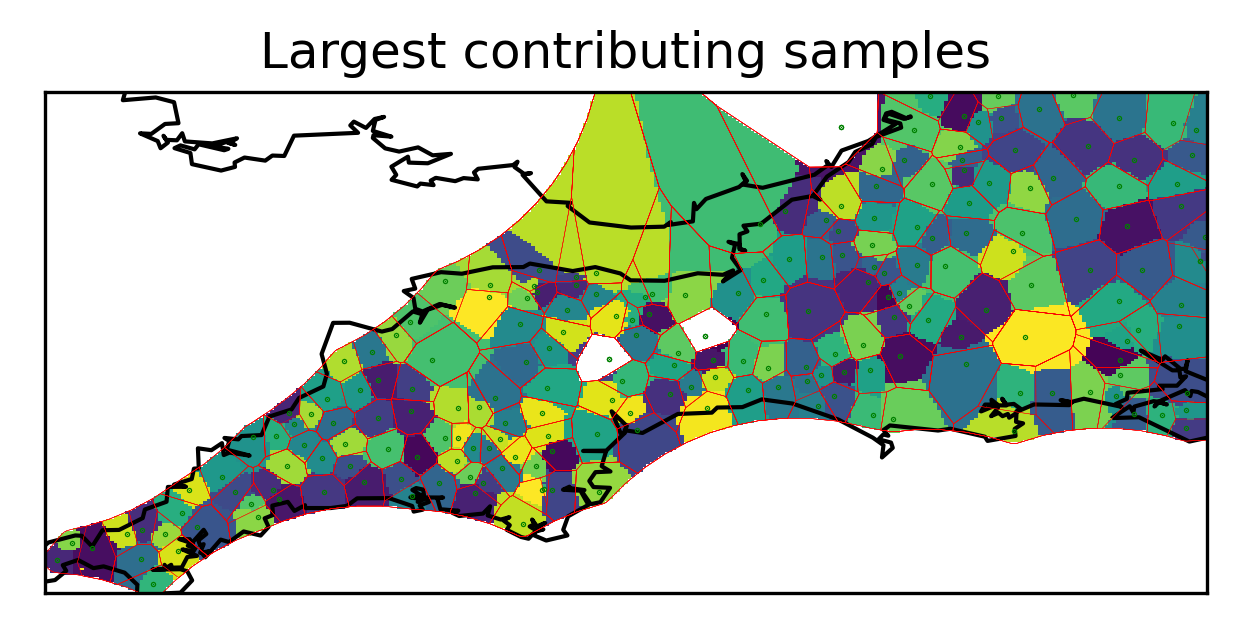

In [340]:
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

m = drawMap(epa_tensor_cornwall, ax)

# colour patches of a common largest sample
x = numpy.linspace(m.llcrnrx, m.urcrnrx, l.shape[0])
y = numpy.linspace(m.llcrnry, m.urcrnry, l.shape[1])
xx, yy = numpy.meshgrid(x, y)

cmap_orig = cm.get_cmap('viridis', l.max() + 1)
c_orig = cmap_orig(numpy.linspace(0.0, 1.0, l.max() + 2))
c_orig[0] = to_rgba('none')
cmap_ext = ListedColormap(c_orig)
norm = Normalize(vmin=-1, vmax=l.max())

m.pcolormesh(xx, yy, l.T, cmap=cmap_ext, norm=norm)

drawVoronoiCells(epa_tensor_cornwall, ax)
  
ax.set_title('Largest contributing samples')

plt.savefig('datasets/cornwall-greatest-contributors.png', dpi=300)
_ = plt.show()

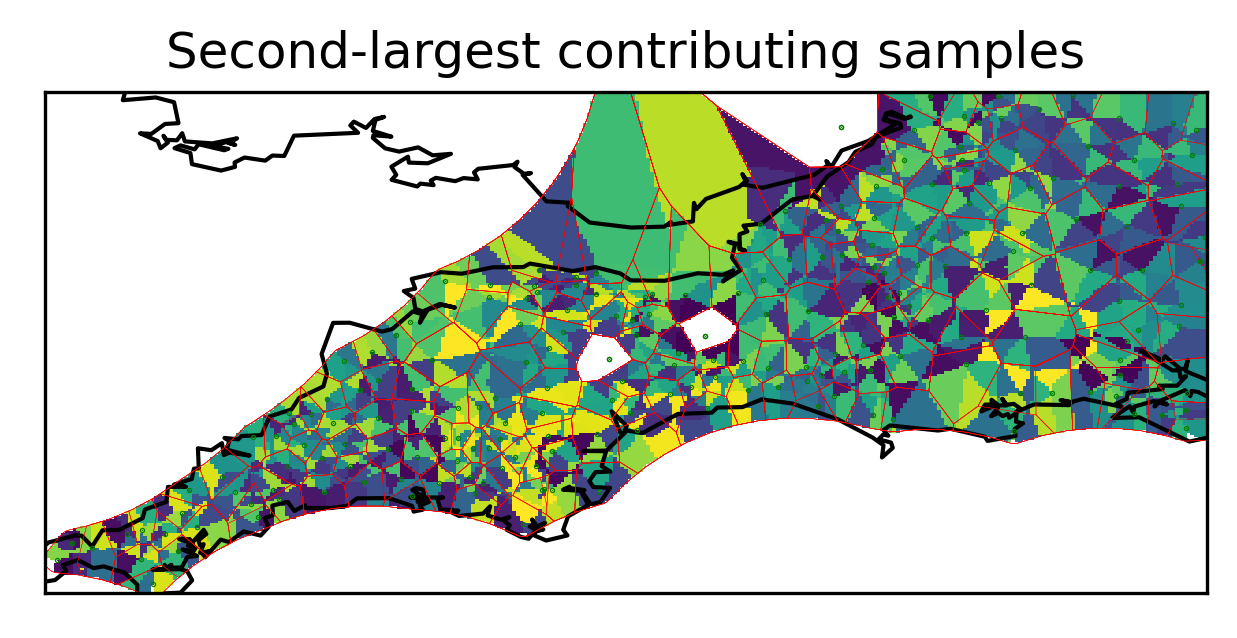

In [339]:
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

m = drawMap(epa_tensor_cornwall, ax)

l2 = largestContributingSamples(epa_tensor_cornwall, 2)

# colour patches of second-largest sample
x = numpy.linspace(m.llcrnrx, m.urcrnrx, l2.shape[0])
y = numpy.linspace(m.llcrnry, m.urcrnry, l2.shape[1])
xx, yy = numpy.meshgrid(x, y)

cmap_orig = cm.get_cmap('viridis', l2.max() + 1)
c_orig = cmap_orig(numpy.linspace(0.0, 1.0, l2.max() + 2))
c_orig[0] = to_rgba('none')
cmap_ext = ListedColormap(c_orig)
norm = Normalize(vmin=-1, vmax=l2.max())

m.pcolormesh(xx, yy, l2.T, cmap=cmap_ext, norm=norm)

drawVoronoiCells(epa_tensor_cornwall, ax)

ax.set_title('Second-largest contributing samples')
    
plt.savefig('datasets/cornwall-second-contributors.png', dpi=300)
_ = plt.show()

In [310]:
l.max()

215

In [318]:
numpy.where(l2 == -1)

(array([  0,   0,   0, ..., 312, 312, 312]),
 array([ 0,  1,  2, ..., 60, 61, 62]))

In [319]:
cmap(-1)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

In [322]:
cmap_ext(0.1)

(0.283072, 0.130895, 0.449241, 1.0)

In [324]:
norm = Normalize(vmin=-1, vmax=l2.max())

In [337]:
cmap_ext(norm(67))

(0.201239, 0.38367, 0.554294, 1.0)

In [334]:
l2.max()

215